In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial
from copy import deepcopy

path = os.path.dirname(os.getcwd())
os.chdir(path)

from src.BayesIMP import *
from src.causalKLGP import *
from src.baselineGP import *
from src.kernels import *
from src.GP_utils import *
from src.training_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [2]:
# DGP set up
d = 5
train_samples = 100
test_samples = 1000
noise_variance = 0.5
input_distribution = torch.distributions.uniform.Uniform(0,1)
mc_samples_EY = 10**4

# PLotting settings
z_val = 1.96

C:\Users\hughw\AppData\Local\Temp\ipykernel_47960\1676995620.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\aten\src\ATen\native\TensorShape.cpp:3679.)
  VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T


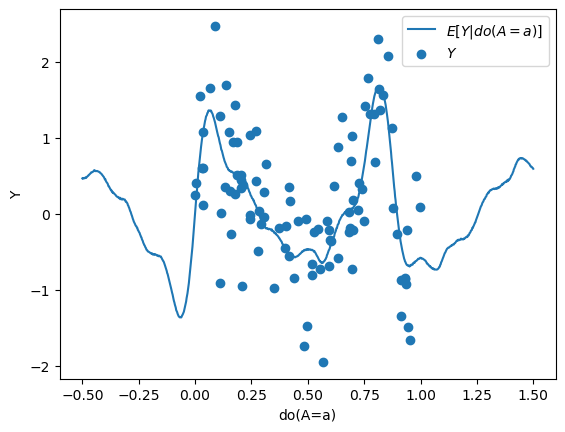

In [3]:
# Dataset generation and plotting E[Y|do(A)]
#torch.random.manual_seed(1) # BASE SEED
torch.random.manual_seed(0)
coefs_v = 10*torch.linspace(1,4,d).view(1,d)
coefs_y = 1/torch.linspace(1,d,d).view(d,)

A = input_distribution.sample((train_samples,1))
doA = torch.linspace(-0.5,1.5,test_samples).view(test_samples,1)
fv = f_x(A,coefs_v)#*A
noise_distribution = Normal(0,(noise_variance*fv.var(0))**0.5)
V = fv+noise_distribution.sample((train_samples,))
fy = f_y(V,coefs_y)#*V[:,0]
Y = Normal(fy,(noise_variance*fy.var())**0.5).sample()

# Grid-points to approximate true E[Y|do(A)]
VdoA = (f_x(doA,coefs_v)).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T
EYdoA = (f_y(VdoA.T,coefs_y)).mean(1).view(test_samples,1)
YdoA = Normal(f_y(VdoA[...,0].T,coefs_y),(noise_variance*fy.var())**0.5).sample()

# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

### Running BayesIMP

In [4]:
# Settings
learn_rate = 0.1
niter = 500
exact = True
mc_samples = 100

C:\Users\hughw\OneDrive\Desktop\causal-KL-GP\src\BayesIMP.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V.var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(245.5894)
iter 100 P(Y|V) loss:  tensor(97.0072)
iter 200 P(Y|V) loss:  tensor(96.9361)
iter 300 P(Y|V) loss:  tensor(96.9327)
iter 400 P(Y|V) loss:  tensor(96.9333)
iter 0 P(V|A) loss:  tensor(3825775.7500)
iter 100 P(V|A) loss:  tensor(67865.1875)
iter 200 P(V|A) loss:  tensor(17177.1914)
iter 300 P(V|A) loss:  tensor(2694.0723)
iter 400 P(V|A) loss:  tensor(-3257.2539)


C:\Users\hughw\OneDrive\Desktop\causal-KL-GP\src\BayesIMP.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V.var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(158.2415)
iter 100 P(Y|V) loss:  tensor(95.6836)
iter 200 P(Y|V) loss:  tensor(95.6824)
iter 300 P(Y|V) loss:  tensor(95.6824)
iter 400 P(Y|V) loss:  tensor(95.6824)
iter 0 P(V|A) loss:  tensor(-18291.9375)
iter 100 P(V|A) loss:  tensor(-29706.6172)
iter 200 P(V|A) loss:  tensor(-29706.6836)
iter 300 P(V|A) loss:  tensor(-29706.6836)
iter 400 P(V|A) loss:  tensor(-29706.6875)
iter 0 P(Y|V) loss:  tensor(248.0753)
iter 100 P(Y|V) loss:  tensor(96.6789)
iter 200 P(Y|V) loss:  tensor(96.5892)
iter 300 P(Y|V) loss:  tensor(96.5362)
iter 400 P(Y|V) loss:  tensor(96.4991)
iter 0 P(V|A) loss:  tensor(36324.5078)
iter 100 P(V|A) loss:  tensor(-19756.9434)
iter 200 P(V|A) loss:  tensor(-19771.5859)
iter 300 P(V|A) loss:  tensor(-19775.4180)
iter 400 P(V|A) loss:  tensor(-19775.6094)
iter 0 P(Y|V) loss:  tensor(158.2415)
iter 100 P(Y|V) loss:  tensor(95.7928)
iter 200 P(Y|V) loss:  tensor(95.6578)
iter 300 P(Y|V) loss:  tensor(95.6577)
iter 400 P(Y|V) loss:  tensor(95

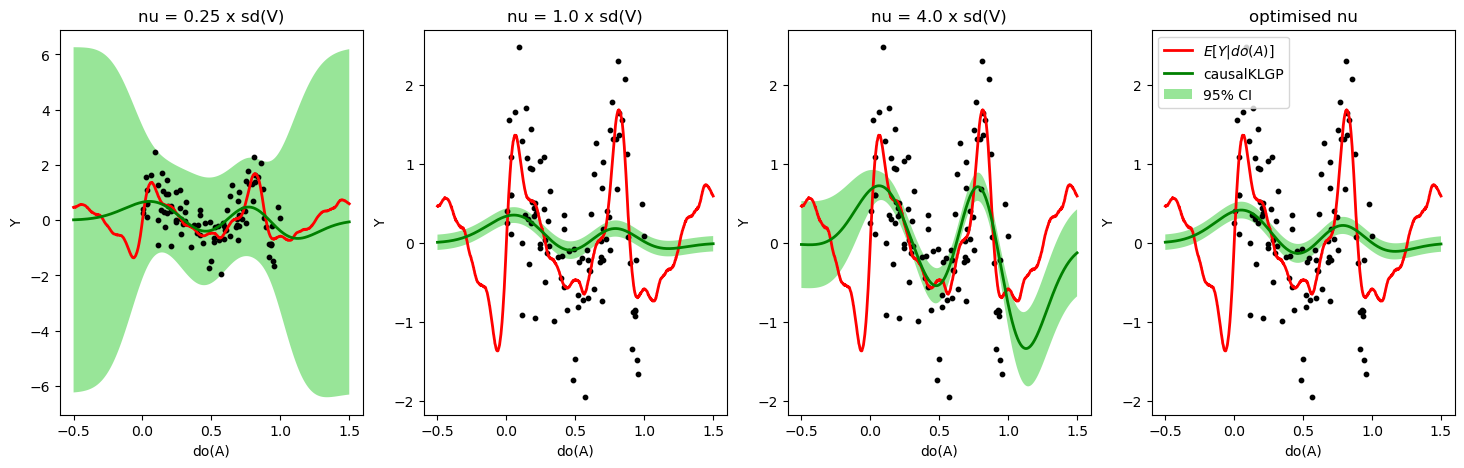

In [5]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(1.0)

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))


Bayesimp_mu = []
Bayesimp_var = []
Bayesimp_var_noise = []

for k in range(len(nulist)):
    

    """Initialising model"""
    model = BayesIMP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5,
                   exact = exact)

    """ Training full model """
    model.train(Y,A,V,niter,learn_rate, optimise_measure = k == len(nulist)-1, measure_init = nulist[k], mc_samples = 100)
        
    # getting post mean predictions
    Bayesimp = deepcopy(model)
    bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
    bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = True).detach()
    bayesimp_var_noise = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = False).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (bayesimp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(bayesimp_var[indices])))
    Lower = (bayesimp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(bayesimp_var[indices])))
    Upper_noise = (bayesimp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(bayesimp_var_noise[indices])))
    Lower_noise = (bayesimp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(bayesimp_var_noise[indices])))
    
    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],bayesimp_mu[indices], label = r"causalKLGP", color = "green", linewidth = 2)
    #axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightgreen",alpha=0.5, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "limegreen",alpha=0.5, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("optimised nu")
        
    Bayesimp_mu.append(bayesimp_mu)
    Bayesimp_var.append(bayesimp_var.diag())
    Bayesimp_var_noise.append(bayesimp_var_noise.diag())
    
plt.legend()
plt.show()

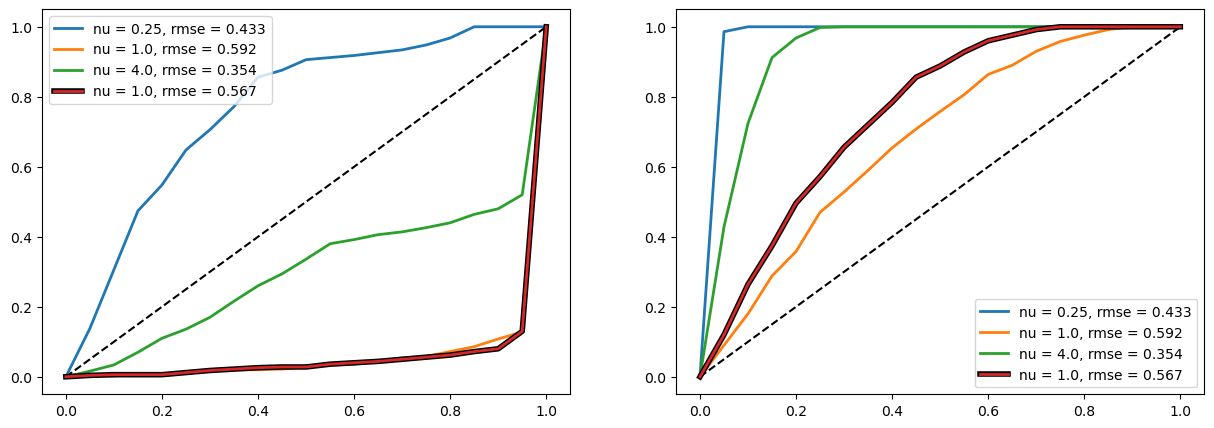

In [6]:
# Getting calibration plots
outline=mpe.withStroke(linewidth=4, foreground='black')
def _round(x, n):
    return int(x*10**n)/10**n

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = Bayesimp_mu[k]
    var = Bayesimp_var[k][:,None]
    var_noise = Bayesimp_var_noise[k][:,None]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((YdoA[inds,None] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    rmse = ((EYdoA[inds] - mean[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(k == len(nulist)-1))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2, path_effects = [outline]*(k == len(nulist)-1))
    axs[0].legend()
    axs[1].legend()

# causalKLGP

In [7]:
"""Initialising model"""
model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1
train_lsA = True

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.1,0.3,0.5,0.7,0.9])

Post_levels, Calibration_losses = model.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                  calibrate_latent = False, calibrate_norm = 1, train_feature_lengthscale = train_lsA)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0][0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(56.9497)
iter 100 P(Y|V) loss:  tensor(50.0457)
iter 200 P(Y|V) loss:  tensor(49.9734)
iter 300 P(Y|V) loss:  tensor(49.9430)
iter 400 P(Y|V) loss:  tensor(49.9259)
iter 0 P(V|A) loss:  tensor(12.9926)
iter 100 P(V|A) loss:  tensor(2.2482)
iter 200 P(V|A) loss:  tensor(2.2470)
iter 300 P(V|A) loss:  tensor(2.2471)
iter 400 P(V|A) loss:  tensor(2.2471)
tensor([0.0880, 0.0840, 0.0840, 0.0760, 0.0560, 0.0360, 0.0360, 0.0360, 0.0360,
        0.0360, 0.0360])


In [8]:
""" Training full model """
model.train(Y,A,V,niter,learn_rate, train_feature_lengthscale = train_lsA)

iter 0 P(Y|V) loss:  tensor(98.5015)
iter 100 P(Y|V) loss:  tensor(96.8636)
iter 200 P(Y|V) loss:  tensor(96.8632)
iter 300 P(Y|V) loss:  tensor(96.8632)
iter 400 P(Y|V) loss:  tensor(96.8632)
iter 0 P(V|A) loss:  tensor(7.3966)
iter 100 P(V|A) loss:  tensor(-4.6177)
iter 200 P(V|A) loss:  tensor(-4.6201)
iter 300 P(V|A) loss:  tensor(-4.6201)
iter 400 P(V|A) loss:  tensor(-4.6202)


nu =  tensor(0.2500)
nu =  tensor(1.)
nu =  tensor(4.)
nu =  tensor(1.)


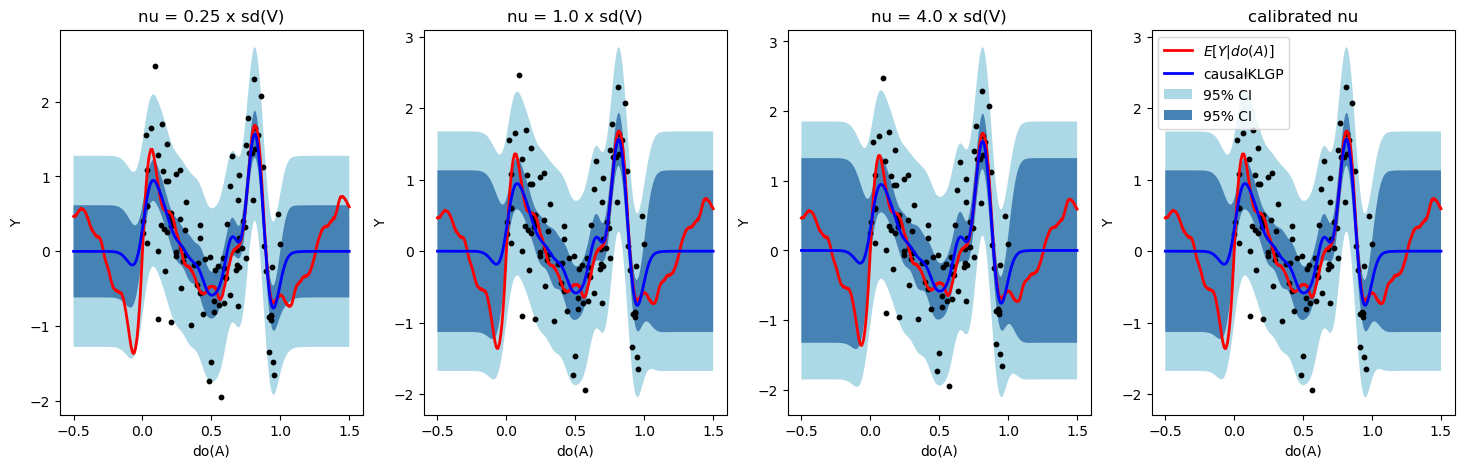

In [9]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(nu_best)

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model)
    causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
    causalklgp_var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach()
    causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Lower = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var[indices])))
    Upper_noise = (causalklgp_mu[indices][:,0]+z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    Lower_noise = (causalklgp_mu[indices][:,0]-z_val*torch.sqrt(torch.diag(causalklgp_var_noise[indices])))
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("calibrated nu")
        
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

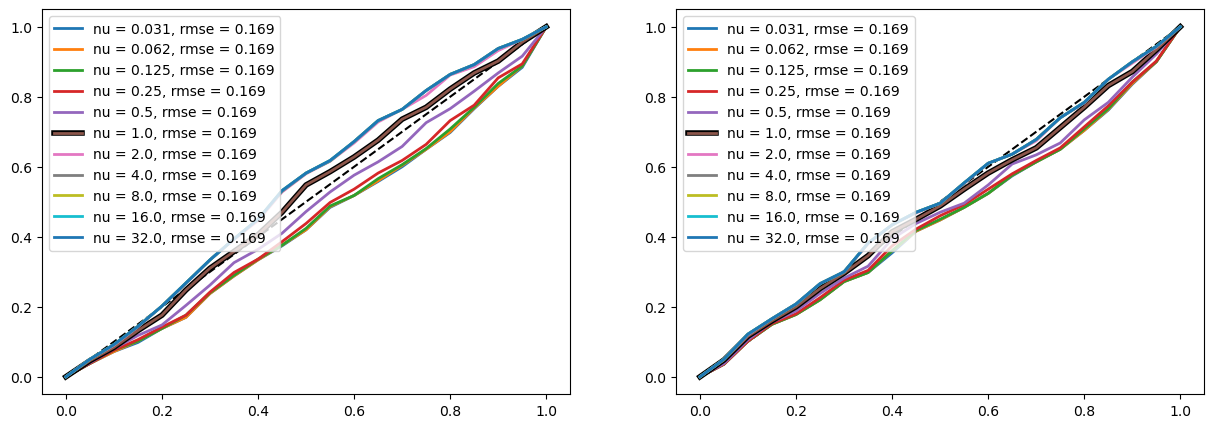

In [10]:
# Getting calibration plots
outline=mpe.withStroke(linewidth=4, foreground='black')
def _round(x, n):
    return int(x*10**n)/10**n

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach().diag()[:,None]
    var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach().diag()[:,None]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((YdoA[inds,None] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    rmse = ((EYdoA[inds] - mean[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

# Nystrom method

In [11]:
"""Initialising model"""
model_nystrom = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.5,0.75,0.9,0.95])

Post_levels, Calibration_losses = model_nystrom.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                          nystrom = True, nystrom_features = 100, nystrom_samples = 10**3,
                                                         calibrate_latent = False, calibrate_norm = 1, train_feature_lengthscale = train_lsA)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0]
nu_best = nulist[best_ind]
print(Calibration_losses)

iter 0 P(Y|V) loss:  tensor(56.9497)
iter 100 P(Y|V) loss:  tensor(50.0457)
iter 200 P(Y|V) loss:  tensor(49.9734)
iter 300 P(Y|V) loss:  tensor(49.9430)
iter 400 P(Y|V) loss:  tensor(49.9259)
iter 0 P(V|A) loss:  tensor(12.9926)
iter 100 P(V|A) loss:  tensor(2.2482)
iter 200 P(V|A) loss:  tensor(2.2470)
iter 300 P(V|A) loss:  tensor(2.2471)
iter 400 P(V|A) loss:  tensor(2.2471)
tensor([0.1150, 0.1150, 0.1200, 0.1050, 0.1250, 0.1150, 0.1200, 0.0950, 0.1000,
        0.2250, 0.2350])


In [12]:
""" Training full model """
model_nystrom.train(Y,A,V,niter,learn_rate, train_feature_lengthscale = train_lsA)

iter 0 P(Y|V) loss:  tensor(98.5015)
iter 100 P(Y|V) loss:  tensor(96.8636)
iter 200 P(Y|V) loss:  tensor(96.8632)
iter 300 P(Y|V) loss:  tensor(96.8632)
iter 400 P(Y|V) loss:  tensor(96.8632)
iter 0 P(V|A) loss:  tensor(7.3966)
iter 100 P(V|A) loss:  tensor(-4.6177)
iter 200 P(V|A) loss:  tensor(-4.6201)
iter 300 P(V|A) loss:  tensor(-4.6201)
iter 400 P(V|A) loss:  tensor(-4.6202)


nu =  tensor(0.2500)
nu =  tensor(1.)
nu =  tensor(4.)
nu =  tensor([4.])


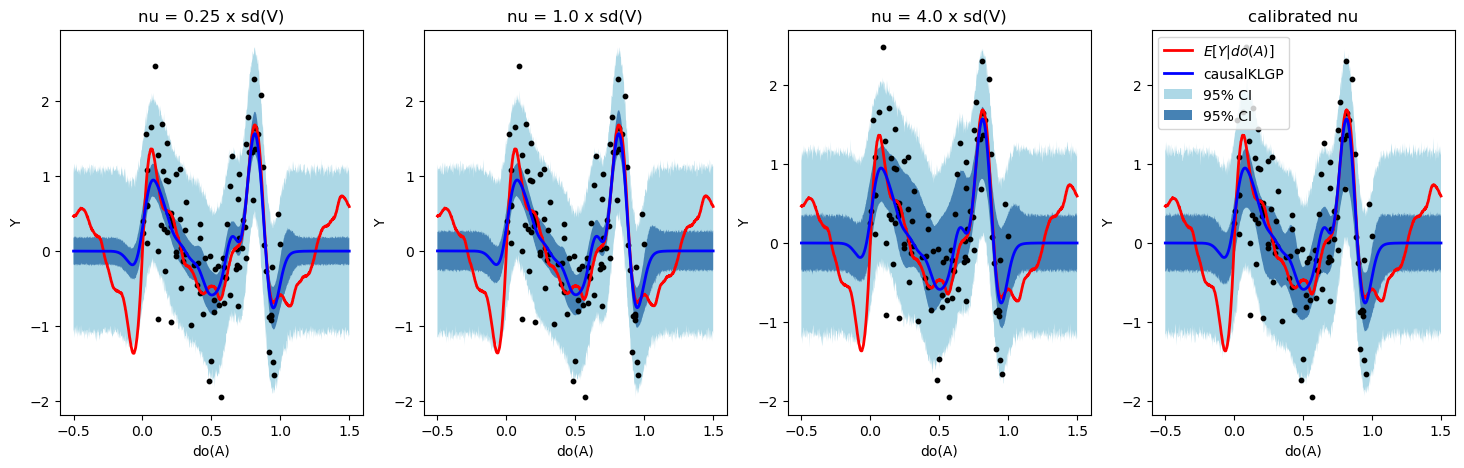

In [13]:
# Getting posterior samples and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(nu_best)
features = 100
samples = 10**3
quantile = 0.95

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model_nystrom)
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    EYdoA_sample,YdoA_sample = causalklgp.nystrom_sample(Y,V,A,doA, reg = 1e-4, features = 100, samples = 10**3, nu = nulist[k])
    
    # Getting CI
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],mean[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],YdoA_sample.quantile(1-(1-quantile)/2,0),YdoA_sample.quantile((1-quantile)/2,0), color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],EYdoA_sample.quantile(1-(1-quantile)/2,0),EYdoA_sample.quantile((1-quantile)/2,0), color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("calibrated nu")    
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

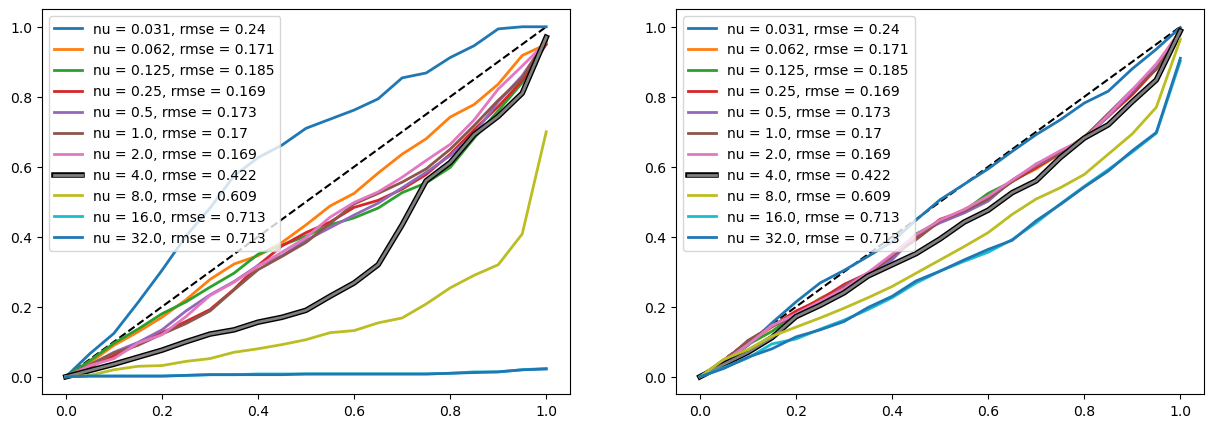

In [14]:
# Calibration plots
samples = 10**3
features = 100

outline=mpe.withStroke(linewidth=4, foreground='black')

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post samples
    EYdoA_sample, YdoA_sample = causalklgp.nystrom_sample(Y.reshape(train_samples,1),V,A,doA,reg = 1e-4, features = features, samples = samples,nu = nulist[k])
    upper_quantiles = 1-(1-levels)/2
    lower_quantiles = (1-levels)/2
    u = (upper_quantiles*(samples-1)).int()
    l = (lower_quantiles*(samples-1)).int()
    Y_u = YdoA_sample.sort(0)[0][u]
    Y_l = YdoA_sample.sort(0)[0][l]
    EY_u = EYdoA_sample.sort(0)[0][u]
    EY_l = EYdoA_sample.sort(0)[0][l]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EY_u[:,inds]>=EYdoA[inds,0])*(EY_l[:,inds]<=EYdoA[inds,0])).float().mean(1)    
    posterior_fraction_y = ((Y_u[:,inds]>=YdoA[inds])*(Y_l[:,inds]<=YdoA[inds])).float().mean(1)
    rmse = ((EYdoA[inds,0]-EYdoA_sample.mean(0)[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

## Baseline GP